# <center>Анализ транзакций пользователей</center>

## <font color='#8D1F29'>Задачи:</font>

**1. Загрузите датасет transaction_data.csv. Проверьте размер таблицы, типы переменных, число пропущенных значений и описательную статистику.**

**2. Какие значения находятся в колонке transaction? Сколько наблюдений относятся к тому или иному уровню? Визуализируйте результат с помощью барплота. Подумайте, как можно улучшить график.**

**3. Сколько транзакций завершились ошибкой?**

**4. Сколько успешных транзакций осуществил каждый из пользователей? Постройте гистограмму распределения числа успешных транзакций.**

**5. Коллега прислал Вам обновленные данные. Постройте сводную таблицу user_vs_minute_pivot, где в качестве столбцов будут использованы имена пользователей, строк – минуты, значений – число совершенных операций в указанную минуту. Пропущенные значения заполните нулями.**

**6. Изучите представленный график. Помогите коллеге разобраться,  есть ли в данных ошибка, или же всё хорошо. Если в данные закралась ошибка, исправьте её и сохраните правильное число минут, прошедших с начала дня, в колонку true_minute.**

## Описание данных

### Имеются следующие данные:

- **date** – дата (2020-03-02 00:00:00 – 2020-03-02 01:29:05)
- **name** – имя пользователя
- **transaction** – статус транзакции
- **minute** – сколько минут прошло с начала дня

In [1]:
# Импорт библиотек
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

**1. Загрузите датасет transaction_data.csv. Проверьте размер таблицы, типы переменных, число пропущенных значений и описательную статистику.**

<font color='navy'>**Вопрос: сколько в датасете пропущенных значений?**</font>

In [2]:
# Считаем данные по транзакциям и посмотрим на первые 5 строк
transactions = pd.read_csv('transactions_data.csv', parse_dates=['date'])
transactions.head()

,date,name,transaction
0,2020-03-02 00:37:20,Ekaterina_Petrova,cancelled
1,2020-03-02 00:59:09,Irina_Fedorova,successfull
2,2020-03-02 01:06:14,Ekaterina_Smirnova,successfull
3,2020-03-02 00:02:58,Lolita_Polyanova,cancelled
4,2020-03-02 00:17:52,Julia_Smirnova,cancelled


In [3]:
# Посмотрим на типы переменных в датафрейме
transactions.dtypes

date           datetime64[ns]
name                   object
transaction            object
dtype: object

In [4]:
# Посмотрим на размерность данных
transactions.shape

(5315, 3)

In [5]:
# Посмотрим на описательную статистику 
transactions.describe()

,date,name,transaction
count,5315,5315,5315
unique,3373,56,3
top,2020-03-02 00:35:03,Masha_Ozerova,successfull
freq,6,112,3692
first,2020-03-02 00:00:00,NaN,NaN
last,2020-03-02 01:29:05,NaN,NaN


In [6]:
# Посмотрим, имеются ли в наших данных пропущенные значения
print(f'Количество пропущенных значений в данных равно {transactions.isna().sum().sum()}')

Количество пропущенных значений в данных равно 0


**2. Проверьте, какие значения принимает колонка transaction . Сколько наблюдений относятся к тому или иному уровню? Визуализируйте результат с помощью барплота.**

<font color='navy'>**Вопрос: расположите уровни переменной в порядке убывания числа относящихся наблюдений (от большего к меньшему).**</font>

In [7]:
# Посчитаем количество значений по состоянию транзакций
transactions_by_state = transactions \
                                .value_counts('transaction') \
                                .to_frame() \
                                .reset_index() \
                                .rename(columns={0:'number'})
transactions_by_state

,transaction,number
0,successfull,3692
1,cancelled,1619
2,error,4


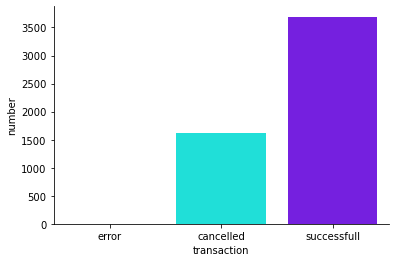

In [8]:
# Визуализируем полученный результат с помощью barplot
transactions_by_state
sns.barplot(x='transaction', y='number', data=transactions_by_state, 
            order=['error', 'cancelled', 'successfull'], palette='hsv')
sns.despine()

#### 3. Сколько транзакций завершились ошибкой?

In [9]:
print(f'Количество транзакций завершившихся ошибкой равно {transactions_by_state.number.min()}')

Количество транзакций завершившихся ошибкой равно 4


**4. Сколько транзакций осуществил каждый из пользователей? Осуществлёнными считаются транзакции со значением successfull. Посмотрите на характеристики распределения, а затем постройте гистограмму числа успешных транзакций, совершённых каждым пользователем.**

In [10]:
ss_transactions_by_users = transactions \
                                .query('transaction == "successfull"') \
                                .groupby('name', as_index=False) \
                                .agg({'transaction': 'count'}) \
                                .rename(columns={'transaction': 'success_num'})
ss_transactions_by_users.head()

,name,success_num
0,Ekaterina_Fedorova,72
1,Ekaterina_Ivanova,59
2,Ekaterina_Lesnova,63
3,Ekaterina_Ozerova,72
4,Ekaterina_Petrova,68


In [11]:
ss_transactions_by_users.describe().T

,count,mean,std,min,25%,50%,75%,max
success_num,56.0,65.928571,7.787769,46.0,61.0,64.0,72.0,82.0


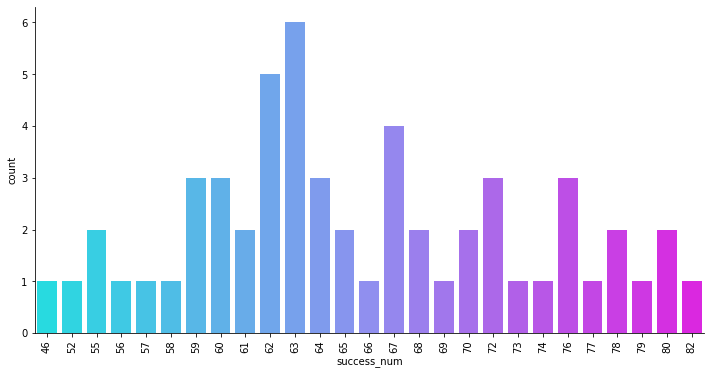

In [12]:
# Визуализируем полученный результат
plt.figure(figsize=(12, 6))
sns.countplot(ss_transactions_by_users.success_num, palette='cool')
plt.xticks(rotation=90)
sns.despine()

**Выводы**
- Пользователи в среднем совершили примерно по 66 транзакций
- Максимальное число транзакций – 82
- Примерно 25% пользователей совершили менее 61 транзакции

#### 5. К вам пришёл коллега с немного обновленными данными. Постройте сводную таблицу user_vs_minute_pivot, где:
- **столбцы – имена пользователей**
- **строки – минута времени осуществления операции (minute)**
- **значения – число совершённых операций**

**Пропущенные значения заполните нулями.**

In [13]:
# Загрузим обновленные данные
transactions_upd = pd.read_csv('transactions_data_updated.csv', parse_dates=['date'])
transactions_upd.head()

,date,name,transaction,minute
0,2020-03-02 00:37:20,Ekaterina_Petrova,cancelled,37
1,2020-03-02 00:59:09,Irina_Fedorova,successfull,59
2,2020-03-02 01:06:14,Ekaterina_Smirnova,successfull,6
3,2020-03-02 00:02:58,Lolita_Polyanova,cancelled,2
4,2020-03-02 00:17:52,Julia_Smirnova,cancelled,17


In [14]:
# Посмотрим на размерность данных
transactions_upd.shape

(5315, 4)

In [15]:
# Посмотрим на типы переменных
transactions_upd.dtypes

date           datetime64[ns]
name                   object
transaction            object
minute                  int64
dtype: object

In [16]:
# Сформируем сводную таблицу по пользователям
user_vs_minute_pivot = transactions_upd.pivot_table(index='minute', columns='name',
                                                    values='transaction', aggfunc='count', fill_value=0)

user_vs_minute_pivot.head(10)

name,Ekaterina_Fedorova,Ekaterina_Ivanova,Ekaterina_Lesnova,Ekaterina_Ozerova,Ekaterina_Petrova,Ekaterina_Polyanova,Ekaterina_Smirnova,Irina_Fedorova,Irina_Ivanova,Irina_Lesnova,...,Svetlana_Petrova,Svetlana_Polyanova,Svetlana_Smirnova,Vasilisa_Fedorova,Vasilisa_Ivanova,Vasilisa_Lesnova,Vasilisa_Ozerova,Vasilisa_Petrova,Vasilisa_Polyanova,Vasilisa_Smirnova
minute,,,,,,,,,,,,,,,,,,,,,
0,3,4,2,3,4,4,2,1,2,2,...,0,3,1,1,4,1,3,0,0,1
1,4,4,0,4,2,5,4,4,4,3,...,4,5,3,2,3,3,0,0,3,2
2,1,2,4,4,2,1,3,2,3,3,...,4,1,3,3,0,1,2,1,3,1
3,3,0,2,0,5,2,1,3,2,2,...,1,5,5,2,4,0,3,4,1,0
4,3,0,0,3,1,1,2,3,2,1,...,1,2,2,1,1,2,2,3,0,1
5,3,0,2,3,1,0,5,3,1,3,...,0,2,3,1,0,0,3,0,2,1
6,4,1,2,2,0,4,5,2,2,2,...,2,1,4,1,2,4,1,2,0,2
7,3,2,1,2,2,3,4,1,1,3,...,3,1,1,2,4,1,0,1,2,2
8,2,4,3,1,0,3,2,1,1,0,...,0,1,0,1,2,4,2,1,1,1


#### 6. Коллега построил следующий график по сводной таблице из предыдущего шага, и сомневается, что в данных нет ошибки:
- **по оси x – минута транзакции (сколько минут прошло с начала дня)**
- **по оси y – число транзакций**
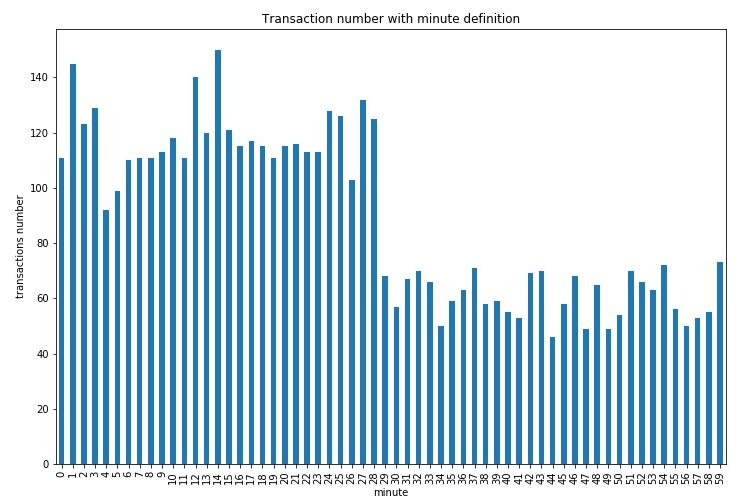

<font color='navy'>**Вопрос: как вы думаете, из-за чего мы видим такую картину? Произошла ошибка, или с данными всё хорошо?**</font>

<AxesSubplot:xlabel='minute'>

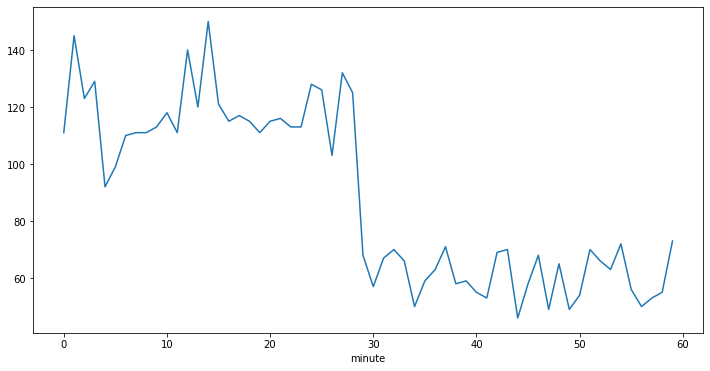

In [17]:
transactions_upd \
            .groupby(['minute'], as_index=False) \
            .agg({'transaction': 'count'}).plot(x='minute', figsize=(12, 6), legend=False)

<font color='#961D28'>**Ошибка в том, что извлекли минутную часть времени, а не число минут с начала дня.**</font>

#### 7. Исправьте ошибку коллеги, и посчитайте число минут, прошедших с начала дня. Результат сохраните в колонку true_minute. Постройте график, как в предыдущем шаге, и посмотрите, произошли ли изменения.

_Создадим дополнительну колонку true_minute, где будет посчитано полное число мину(сумма минут во времени и часов во времени, умноженные на 60)._

In [18]:
transactions_upd['true_minute'] = (transactions_upd.date.dt.hour * 60) + transactions_upd.date.dt.minute
transactions_upd.head()

,date,name,transaction,minute,true_minute
0,2020-03-02 00:37:20,Ekaterina_Petrova,cancelled,37,37
1,2020-03-02 00:59:09,Irina_Fedorova,successfull,59,59
2,2020-03-02 01:06:14,Ekaterina_Smirnova,successfull,6,66
3,2020-03-02 00:02:58,Lolita_Polyanova,cancelled,2,2
4,2020-03-02 00:17:52,Julia_Smirnova,cancelled,17,17


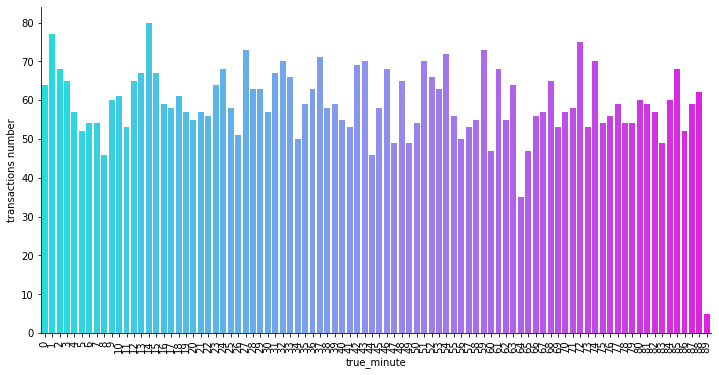

In [19]:
# Построим график по колонке true_minute
plt.figure(figsize=(12, 6))
sns.countplot(transactions_upd.true_minute, palette='cool')
plt.xticks(rotation=90)
plt.ylabel('transactions number')
sns.despine()

<font color='#961D28'>**Распределение стало более равномерным!!!**</font>